In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold

#these values obtained from calculating pearson correlation between the L and R input signals
lowest_classes = [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7))]

run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]

    # Extract LFP signals
    left_input_LFP = data['LFP'][0][0]
    right_input_LFP = data['LFP'][0][1]
    attention_LFP = data['LFP_rec'][0][2]

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices][:, 100:350]
                right_input_LFP_attleft = right_input_LFP[left_indices][:, 100:350]
                attention_LFP_attleft = attention_LFP[left_indices][:, 100:350]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices][:, 100:350]
                right_input_LFP_attright = right_input_LFP[right_indices][:, 100:350]
                attention_LFP_attright = attention_LFP[right_indices][:, 100:350]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_LFP_attleft_all = copy.deepcopy(all_structure)
right_input_LFP_attleft_all = copy.deepcopy(all_structure)
attention_LFP_attleft_all = copy.deepcopy(all_structure)

left_input_LFP_attright_all = copy.deepcopy(all_structure)
right_input_LFP_attright_all = copy.deepcopy(all_structure)
attention_LFP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
#looking first at the shape / structure of left_input_LFP_attleft_all:
print('left_input_LFP_attleft_all 00 raw =', left_input_LFP_attleft_all[f'left_class_{0}'][f'right_class_{0}'])
print('left_input_LFP_attleft_all 01 raw =', left_input_LFP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])

for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('left_input_LFP_attleft_all 00 reshaped = ', left_input_LFP_attleft_all[f'left_class_{0}'][f'right_class_{0}'])
print('left_input_LFP_attleft_all 01 reshaped = ', left_input_LFP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])

def preprocess_data(data):
    # data = detrend(data, axis = 0)   #data seems to look nicer if i do this

    for i in range(len(data)):
        data[i] = detrend(data[i])

    data = zscore(data, axis = 0)
    return data

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])  

print('left_attleft 00 =', left_attleft[f'left_class_{0}'][f'right_class_{0}'])
print('left_attleft 01 =', left_attleft[f'left_class_{0}'][f'right_class_{1}'])

   
n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


Dataset 1 loaded in 24.98 seconds
Dataset 1 processed in 1.40 seconds
Dataset 2 loaded in 6.36 seconds
Dataset 2 processed in 0.60 seconds
Dataset 4 loaded in 6.66 seconds
Dataset 4 processed in 0.47 seconds
Dataset 8 loaded in 6.25 seconds
Dataset 8 processed in 0.48 seconds
Dataset 14 loaded in 5.32 seconds
Dataset 14 processed in 0.47 seconds
Dataset 15 loaded in 5.45 seconds
Dataset 15 processed in 0.46 seconds
Dataset 20 loaded in 5.98 seconds
Dataset 20 processed in 0.46 seconds
Dataset 23 loaded in 4.98 seconds
Dataset 23 processed in 0.44 seconds
Total load time = 70.83 seconds
left_input_LFP_attleft_all 00 raw = [array([[2286.63647461, 2533.57226562, 2464.61669922, ..., 2206.48339844,
        2102.62011719, 2121.69702148]]), array([[3743.17333984, 3912.57836914, 3883.77758789, ..., 1596.20092773,
        1514.89135742, 1577.23168945]]), array([[1694.01342773, 1805.81994629, 1770.04833984, ..., 1808.1418457 ,
        1728.20043945, 1823.42504883]])]
left_input_LFP_attleft_all 0

(9, 250)
20
pearson calculated for all left 19 in 1741801768.90 seconds
pearson calculated for all right 19 in 1741801773.14 seconds
[np.float64(0.23439954479499228), np.float64(-0.015184807849544096), np.float64(-0.265654869451494), np.float64(-0.2298356067575709), np.float64(0.15969104448866492), np.float64(0.11530716844772472), np.float64(0.022702860683001407), np.float64(0.06010027246954699)]
Total run time = 75.29 seconds


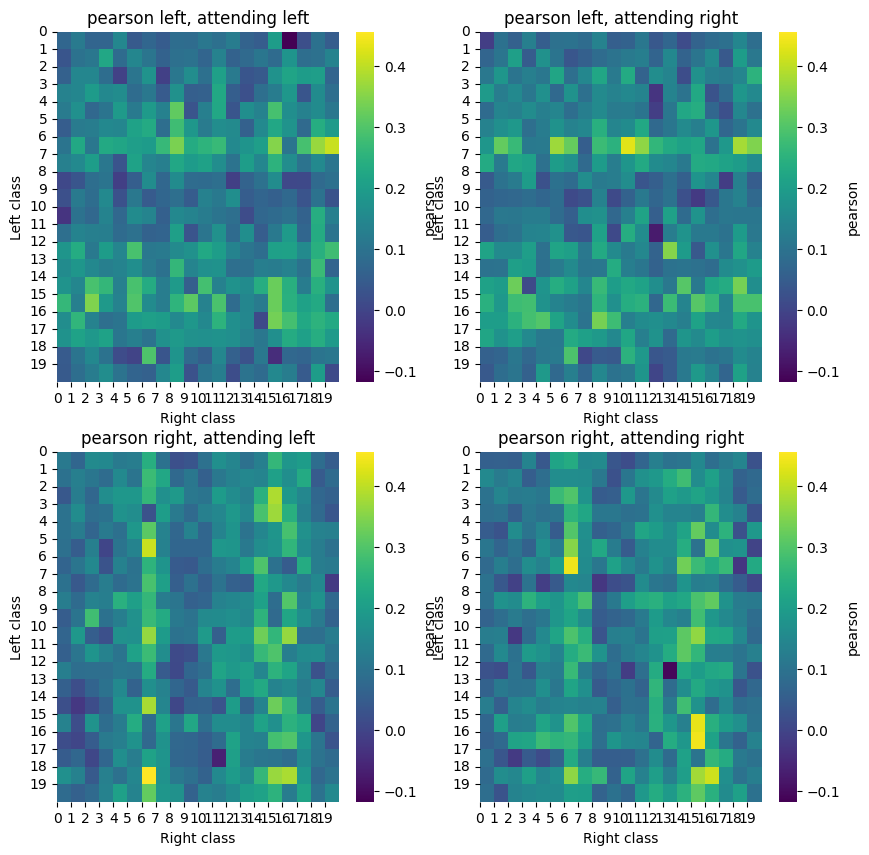

In [2]:
print(np.array(left_attleft[f'left_class_{0}'][f'right_class_{1}']).shape)
print(len(left_input_LFP_attleft_all))
#-------------pearson calculation----------------
lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}

pearson_values = copy.deepcopy(lr_split_structure)
pearson_stdevs = copy.deepcopy(lr_split_structure)

pearson_start = time.time()
for class_left in classes_left:

    for class_right in classes_right: 

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue   

        for i in range(len(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])):
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'].append(pearsonr(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'].append(pearsonr(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])

print(f"pearson calculated for all left {class_left} in {pearson_start:.2f} seconds")

pearson_start = time.time()
for class_left in classes_left:
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            continue   

        for i in range(len(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])):
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'].append(pearsonr(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'].append(pearsonr(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
                                                                                               
print(f"pearson calculated for all right {class_left} in {pearson_start:.2f} seconds")

       
print(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'])

run_time = time.time() - run_time
print(f"Total run time = {run_time:.2f} seconds")


#--------plotting the results-------------
results_to_plot = copy.deepcopy(lr_split_structure)

for class_left in classes_left:
    for class_right in classes_right:
        for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
            results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = np.mean(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}'][key])


results_to_plot_low =  copy.deepcopy(lr_split_structure)

for class_left in classes_left:
    for class_right in classes_right:
        if (class_left, class_right) in lowest_classes:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = np.mean(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}'][key])
        else:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = -1


#==============================plotting heatmaps================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin, vmax = calculate_vmin_vmax(results_to_plot, classes_left, classes_right)



fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] for class_right in classes_right] for class_left in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,0].set_xticks(np.arange(0, 20))
ax[0,0].set_yticks(np.arange(0, 20))
ax[0,0].set_xticklabels(classes_right)
ax[0,0].set_yticklabels(classes_left)
ax[0,0].set_xlabel('Right class')
ax[0,0].set_ylabel('Left class')
ax[0,0].set_title(f'pearson left, attending left')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,0].set_xticks(np.arange(0, 20))
ax[1,0].set_yticks(np.arange(0, 20))
ax[1,0].set_xticklabels(classes_right)
ax[1,0].set_yticklabels(classes_left)
ax[1,0].set_xlabel('Right class')
ax[1,0].set_ylabel('Left class')
ax[1,0].set_title(f'pearson right, attending left')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] for class_right in classes_right] for class_left in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,1].set_xticks(np.arange(0, 20))
ax[0,1].set_yticks(np.arange(0, 20))
ax[0,1].set_xticklabels(classes_right)
ax[0,1].set_yticklabels(classes_left)
ax[0,1].set_xlabel('Right class')
ax[0,1].set_ylabel('Left class')
ax[0,1].set_title(f'pearson left, attending right')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,1].set_xticks(np.arange(0, 20))
ax[1,1].set_yticks(np.arange(0, 20))
ax[1,1].set_xticklabels(classes_right)
ax[1,1].set_yticklabels(classes_left)
ax[1,1].set_xlabel('Right class')
ax[1,1].set_ylabel('Left class')
ax[1,1].set_title(f'pearson right, attending right')

plt.show()



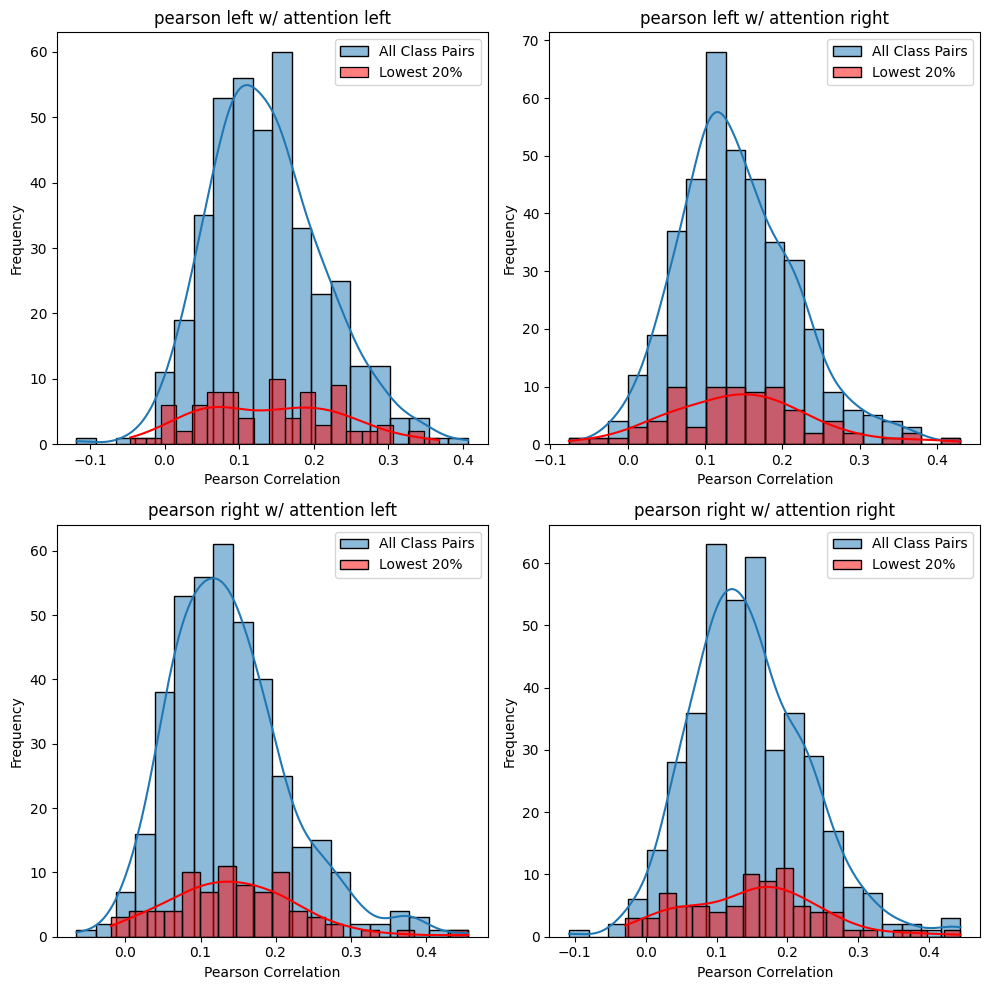

In [5]:
#==============================histograms================================
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the extracted wSMI values into 1D lists before plotting
hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,0].set_title('pearson left w/ attention left')
ax[0,0].set_xlabel('Pearson Correlation')
ax[0,0].set_ylabel('Frequency')
ax[0,0].legend()

# Repeat for the other plots
hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,0].set_title('pearson right w/ attention left')
ax[1,0].set_xlabel('Pearson Correlation')
ax[1,0].set_ylabel('Frequency')
ax[1,0].legend()

hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,1].set_title('pearson left w/ attention right')
ax[0,1].set_xlabel('Pearson Correlation')
ax[0,1].set_ylabel('Frequency')
ax[0,1].legend()

hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,1].set_title('pearson right w/ attention right')
ax[1,1].set_xlabel('Pearson Correlation')
ax[1,1].set_ylabel('Frequency')
ax[1,1].legend()

plt.tight_layout()
plt.show()